In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable

In [3]:
# Please change the file location to reproduce the results
train = pd.read_csv('C:/A_Work/UIC/Courses/Deep Learning/HW1/digit-recognizer/train.csv', header = 0, sep = ',')
test = pd.read_csv('C:/A_Work/UIC/Courses/Deep Learning/HW1/digit-recognizer/test.csv', header = 0, sep = ',')

0


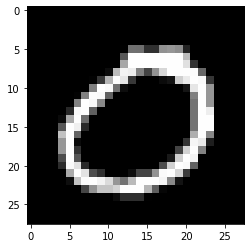

1


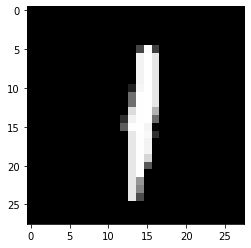

2


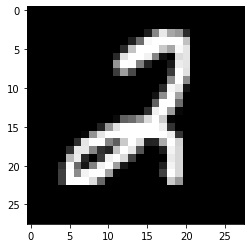

3


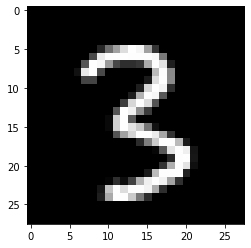

4


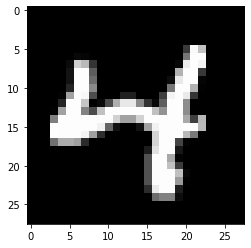

5


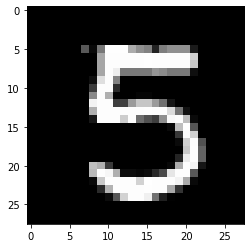

6


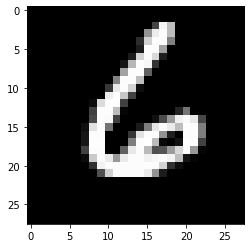

7


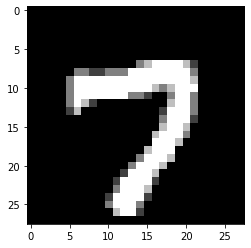

8


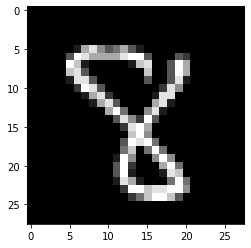

9


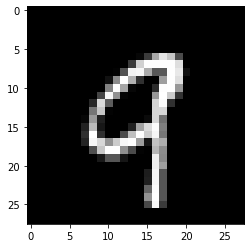

In [5]:
# SOLUTION 5(a) - Visualizing each label's atleast one image
for i in range(10):
    indx = max(train.index[train['label'] == i].tolist())
    
    image = train.iloc[indx,1:].to_numpy()
    
    label = train.iloc[indx,0]
    
    print(label)
    image = image.reshape(28, 28)
    plt.imshow(image)
    plt.gray()
    plt.show()

Text(0.5, 1.0, 'Histogram of Label')

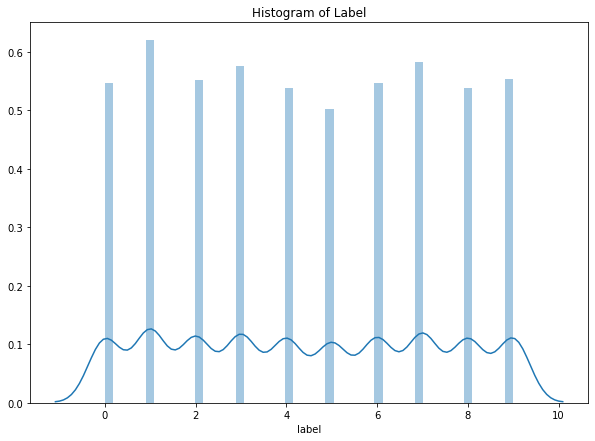

In [6]:
# SOLUTION 5 (b) - Distribution of labels (approximately uniform)

fig, ax = plt.subplots(figsize=(10, 7))
sns.distplot(train['label'], norm_hist = True, bins = 50).set_title("Histogram of Label")

In [7]:
# We can see using above plot that alll categories are approximately uniform. There are a few categories ex 1, 3, 7 which have more examples than others

In [4]:
X1 = train.drop('label', axis = 1).values
y1 = train['label'].values

In [9]:
# Train Test split (Keeping same for Logistic and Neural Network)
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=11)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

KeyboardInterrupt: 

In [ ]:
######################################### Logistic Regression #####################################################

In [ ]:
# SOLUTION 5 (c) - Logistic Regression is used for classification task 
# Note: We have also performed paramter tuning and also tested both L1 and L2 regularizers
# Ranges of hyper-parameters are selected by running multiple runs
# we are also using 5 fold cross validation for parameter tuning for better generalization of model on training data
# Using results of tuned hyperparamters, we will retrain the model with complete training data (for prediction); however we perform 80-20% split for assignment result purpose to report accuracy and compare it with neural network

# Paramters to tune
penal = ["l1", "l2"]
tolerance = [0.25, 0.1]
lamda = [50, 25]

# Initializing empty arrays to store results
spars = np.zeros([len(penal), len(tolerance), len(lamda)])
acc = np.zeros([len(penal), len(tolerance), len(lamda)])

# Loops with parameter values and 5 fold cross validation
for i in range(len(penal)):
    pen = penal[i]
    for j in range(len(tolerance)):
        toln = tolerance[j]
        for k in range(len(lamda)):
            lam = lamda[k]
            
            sparsity = []
            accuracy = []
                   
            #10-fold cross validation on training data (400 rows)
            n_splits = 5
            kf = KFold(n_splits=n_splits, shuffle=False, random_state = 10)
            
            for training, testing in kf.split(train):
                df_trainx = train.drop("label", axis = 1).iloc[training]
                df_trainy = train["label"].iloc[training]
                df_testx = train.drop("label", axis = 1).iloc[testing]
                df_testy = train["label"].iloc[testing]
            
                clf = LogisticRegression(C=lam/df_trainx.shape[0], penalty=pen, solver='saga', tol=toln)
                clf.fit(df_trainx, df_trainy)
                sparI = np.mean(clf.coef_ == 0) * 100
                accuI =  clf.score(df_testx, df_testy)
                
                sparsity.append(sparI)
                accuracy.append(accuI)
                
            mean_spars = sum(sparsity)/len(sparsity)
            mean_accu = sum(accuracy)/len(accuracy)
            
            spars[i, j, k] = mean_spars
            acc[i, j, k] = mean_accu
            print(i, j, k)
            

penal_indx_cv, tolerance_indx_cv, lamda_indx_cv = np.where(spars == spars.min())
penal_indx_test, tolerance_indx_test, lamda_indx_test = np.where(acc == acc.min())

In [ ]:
# Indices of best parameters
penal_indx_cv, tolerance_indx_cv, lamda_indx_cv

In [ ]:
# Best parameters for training 80% of data on train.csv and results will be used to compare with neural network
pen_f = penal[penal_indx_cv[0]]
lam_f = lamda[lamda_indx_cv[0]]
tol_f = tolerance[tolerance_indx_cv[0]]

In [ ]:
# Training and testing logistic regression using best parameters

clf_f = LogisticRegression(C=lam_f/X_train.shape[0], penalty=pen_f, solver='saga', tol=tol_f)
clf_f.fit(X_train, y_train)
sparsity_f = np.mean(clf_f.coef_ == 0) * 100
score_f = clf_f.score(X_test, y_test)
# print('Best C % .4f' % clf.C_)
print("Sparsity with best paramters: %.2f%%" % sparsity_f)
print("Test score with best parameters: %.4f" % score_f)

In [ ]:
# We get accuracy of 86% with logistic regression

In [ ]:
# Visualizing weight vector

coef = clf_f.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()
for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(coef[i].reshape(28, 28), interpolation='nearest',
                   cmap=plt.cm.RdBu, vmin=-scale, vmax=scale)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel('Class %i' % i)
plt.suptitle('Classification vector for...')
plt.show()

In [ ]:
# As we want to score test data (for competition)
clf_score = LogisticRegression(C=lam_f/X_train.shape[0], penalty=pen_f, solver='saga', tol=tol_f)
clf_score.fit(X_train, y_train)
prediction_test = clf_score.predict(test)

In [ ]:
# SOLUTION 5 (d)
# Now we will be building multi layer perceptron using pytorch
# We are building two kinds of neural network (one with 1 hidden layer and one with 2 hidden layer)
# We will also perform hyper-paramter tuning for both the neural networks for better performance and will compare results with previous trained logistic regression for same train test split
# We are using pytorch (we have excluded utilization of GPU for this exercise)

In [ ]:
################################ Neural Network with One Hidden layer and 100 Neurons ####################################

In [5]:
y1

array([1, 0, 1, ..., 7, 6, 9], dtype=int64)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=11)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
y_test

array([1, 7, 2, ..., 2, 6, 2], dtype=int64)

In [8]:
# create feature and targets tensor for train set.
featuresTrain = torch.from_numpy(X_train)
targetsTrain = torch.from_numpy(y_train).type(torch.LongTensor)

featuresTest = torch.from_numpy(X_test)
targetsTest = torch.from_numpy(y_test).type(torch.LongTensor)

In [9]:
# Initializing batch size (can be tuned but doesn't influence the performance a lot and hence kept fixed after trying multiple values)
batch_size = 100
# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)


In [10]:
targetsTrain

tensor([0, 0, 8,  ..., 2, 4, 2])

In [ ]:
# Create ANN Model (This is model 1 with one hidden layer ex. hidden neurons=100)
class ANNModel1(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANNModel1, self).__init__()
        # Linear function 1: 784 --> 100
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        # Non-linearity 1
        self.relu1 = nn.ReLU()
        
        # Linear function 2: 100 --> 10
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        # Non-linearity 2
        self.elu2 = nn.ELU()
         
    
    def forward(self, x):
        # Linear function 1
        out = self.fc1(x)
        # Non-linearity 1
        out = self.relu1(out)
        
        # Linear function 2
        out = self.fc2(out)
        # Non-linearity 2
        out = self.elu2(out)
 
        return out



In [ ]:
# instantiate ANN
input_dim = 28*28
output_dim = 10

# hyper-parameters for tuning
hidden = [250, 100]
learn = [0.1, 0.01, 0.001]
num_epochs = [20, 50]
incorrect_ex = []

accuracy_f = np.zeros([len(hidden), len(learn), len(num_epochs)])

for i in range(len(hidden)):
    hidden_dim = hidden[i]
    for j in range(len(learn)):
        learning_rate = learn[j]
        
        model = ANNModel1(input_dim, hidden_dim, output_dim)
        error = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        
        for k in range(len(num_epochs)):
            num_ep = num_epochs[k]
            
            for epoch in range(num_ep):
                for l, (images, labels) in enumerate(train_loader):

                    train = Variable(images.view(-1, 28*28))
                    labels = Variable(labels)

                    # Clear gradients
                    optimizer.zero_grad()

                    # Forward propagation
                    outputs = model(train.float())

                    # Calculate softmax and ross entropy loss
                    loss = error(outputs, labels)

                    # Calculating gradients
                    loss.backward()

                    # Update parameters
                    optimizer.step()

            # Calculate Accuracy         
            # Predict test dataset
            total = 0
            correct = 0
            incorr = []
            count = 0
            for images, labels in test_loader:

                test = Variable(images.view(-1, 28*28))

                # Forward propagation
                outputs = model(test.float())

                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]

                # Total number of labels
                total += len(labels)

                # Total correct predictions
                correct += (predicted == labels).sum()
                
                incorrect = torch.eq(predicted,labels)
                indx = (incorrect == False).nonzero()
                list = [element.item() for element in indx.flatten()]
                incorr.append(list)
                
                count += 1
            
            flat_list = [val for sublist in incorr for val in sublist]

            accuracy = 100 * correct / float(total)
            
            
            incorrect_ex.append(flat_list)
            
            accuracy_f[i, j, k] = accuracy
            print(i,j,k)

In [ ]:
print("Test score with best parameters: %.4f" % accuracy_f.max())

In [ ]:
# The best accuracy obtained with single layer neural network is 96% much higher than best parameter logistic regression which was 86%

In [ ]:
hidden_indx, learn_indx, epoch_indx = np.where(accuracy_f == accuracy_f.max())

In [ ]:
print("The best parameters for neural network with one hidden layer and varying number of hidden neurons are:")
print("Number of Hidden Neurons: ", hidden[hidden_indx[0]])
print("Learning Rate: ", learn[learn_indx[0]])
print("Number of epochs: ", num_epochs[epoch_indx[0]])

In [ ]:
# Now lets visualize the interesting and wrong classified image examples with 1 hidden layer neural network
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=11)
test_x = pd.DataFrame(X_test)
test_y = pd.DataFrame(y_test)

plt.figure(figsize=(20, 20))

indx = incorrect_ex[0]
for i in range(len(indx)):
    ind = indx[i]
#         print("indx", ind)

    image = test_x.iloc[ind,:].to_numpy()

    label = test_y.iloc[ind,0]

#         print(label)
    image = image.reshape(28, 28)

    l1_plot = plt.subplot(17, 17, i+1)

    l1_plot.imshow(image)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel('Class %i' % label)

plt.suptitle('Wrongly classified image')
plt.show()    


In [ ]:
# It is clearly visible that above images have confusing structure; which might confuse model and resulting in wrong classification

In [ ]:
# We can see that single layer neural network has outperformed logistic regression with best paramters with best regularization method (L2) for this dataset 

In [ ]:
############################### Neural Network with 2 hidden layers #################################### 

In [ ]:
# Create ANN Model
class ANNModel2(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(ANNModel2, self).__init__()
        # Linear function 1: 784 --> 100
        self.fc1 = nn.Linear(input_dim, hidden_dim1) 
        # Non-linearity 1
        self.relu1 = nn.ReLU()
        
        # Linear function 2: 100 --> 25
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        # Non-linearity 2
        self.elu2 = nn.ELU()
        
        # Linear function 3: 25 --> 10
        self.fc3 = nn.Linear(hidden_dim2, output_dim)
        self.elu3 = nn.ELU()

    def forward(self, x):
        # Linear function 1
        out = self.fc1(x)
        # Non-linearity 1
        out = self.relu1(out)
        
        # Linear function 2
        out = self.fc2(out)
        # Non-linearity 2
        out = self.elu2(out)
        
        # Linear function 2
        out = self.fc3(out)
        # Non-linearity 2
        out = self.elu3(out)
        
        return out


In [ ]:
# instantiate ANN
input_dim = 28*28
output_dim = 10

hidden1 = [250, 100]
hidden2 = [25, 50]
learn = [0.1, 0.01]
num_epochs = [20, 50]

accuracy_f = np.zeros([len(hidden1), len(hidden2), len(learn), len(num_epochs)])

incorrect_ex2 = []

for m in range(len(hidden2)):
    hidden_dim2 = hidden2[m]
    for i in range(len(hidden1)):
        hidden_dim1 = hidden1[i]
        for j in range(len(learn)):
            learning_rate = learn[j]

            model = ANNModel2(input_dim, hidden_dim1, hidden_dim2, output_dim)
            error = nn.CrossEntropyLoss()
            optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

            for k in range(len(num_epochs)):
                num_ep = num_epochs[k]

                for epoch in range(num_ep):
                    for l, (images, labels) in enumerate(train_loader):

                        train = Variable(images.view(-1, 28*28))
                        labels = Variable(labels)

                        # Clear gradients
                        optimizer.zero_grad()

                        # Forward propagation
                        outputs = model(train.float())

                        # Calculate softmax and ross entropy loss
                        loss = error(outputs, labels)

                        # Calculating gradients
                        loss.backward()

                        # Update parameters
                        optimizer.step()

                # Calculate Accuracy         
                # Predict test dataset
                total = 0
                correct = 0
                count = 0
                for images, labels in test_loader:

                    test = Variable(images.view(-1, 28*28))

                    # Forward propagation
                    outputs = model(test.float())

                    # Get predictions from the maximum value
                    predicted = torch.max(outputs.data, 1)[1]

                    # Total number of labels
                    total += len(labels)

                    # Total correct predictions
                    correct += (predicted == labels).sum()
                    
                    incorrect = torch.eq(predicted,labels)
                    indx = (incorrect == False).nonzero()
                    list = [element.item() for element in indx.flatten()]
                    incorr.append(list)
                    
                    count += 1
                
                flat_list = [val for sublist in incorr for val in sublist]

                accuracy = 100 * correct / float(total)
                
                incorrect_ex2.append(flat_list)

                accuracy_f[m, i, j, k] = accuracy
                print(m, i,j,k)

In [ ]:
print("Test score with best parameters: %.4f" % accuracy_f.max())

In [ ]:
# The accuracy has even increased with 2 hidden layers after tuning for both layers hidden neurons, epochs and learning rate

In [ ]:
hidden_indx1, hidden_indx2, learn_indx, epoch_indx = np.where(accuracy_f == accuracy_f.max())

In [ ]:
print("The best parameters for neural network with two hidden layer and varying number of hidden neurons in both are :")
print("Number of Hidden Neurons in layer one: ", hidden1[hidden_indx1[0]])
print("Number of Hidden Neurons in layer two: ", hidden2[hidden_indx2[0]])
print("Learning Rate: ", learn[learn_indx[0]])
print("Number of epochs: ", num_epochs[epoch_indx[0]])

In [ ]:
# Now lets visualize the interesting and wrong classified image examples with 1 hidden layer neural network
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=11)
test_x = pd.DataFrame(X_test)
test_y = pd.DataFrame(y_test)

plt.figure(figsize=(20, 20))

indx = incorrect_ex2[0]
for i in range(len(indx)):
    ind = indx[i]
#         print("indx", ind)

    image = test_x.iloc[ind,:].to_numpy()

    label = test_y.iloc[ind,0]

#         print(label)
    image = image.reshape(28, 28)

    l1_plot = plt.subplot(17, 17, i+1)

    l1_plot.imshow(image)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel('Class %i' % label)

plt.suptitle('Wrong classified image.. ')
plt.show()    
  

In [ ]:
# In Conclusion we can say that; 2 hidden layer neural network outperformed 1 hidden layer neural network and logistic regression with accuracy of more than 97%. We could find some confusing images which were predicted wrongly by our neural network models